 <center> <h1> <b> Pattern Recognition and Machine Learning (EE5607) </b> </h1> </center>

<b> Programming Assignment - 04 - Neural Networks</b>

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.



<b> Assignment on Neural Networks </b> <br>
This programming assignment gives you a chance to perform the classification task using neural networks. You will get to build a neural network from scratch and train and test it on a standard classification dataset. Further you will learn different tricks and techniques to train a neural network eficiently by observing few important issues and trying to overcome them. This includes observing the performance of the network for different activation functions and optimization algorithms. We will conclude with implementation of various regularization techniques and ResNet to overcome the problems of overfitting and vanishing gradients.

In [4]:
#All imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

%matplotlib notebook

np.random.seed(6996)

<b>  Part - (1) : Train a classification network from scratch </b> 
1. Load MNIST data and create train, test splits
2. Design a simple classification network


> Network should consists of three Dense Layers with 512 nodes. The same architecture is used throughout the assignment to understand the effect of hyper parameters.

> Use stochastic gradient descent optimization algorithm to update the parameters. You can use the learning rate suitable for the MNIST digit classification problem.

> Use ReLU activation function in the first two layers. Softmax activation function should be used at the last layer to get the posterior probability of the classes.






3. Train the network using MNIST training data and evaluate the performance on MNIST test data



In [8]:
##################################################
#Load MNIST data.
##################################################


from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt

# drive.mount('/content/drive',force_remount=True)
# root_path='/content/drive/MyDrive/PRMLAssignments/ProgrammingAssignment-01'
root_path='/home/spcup2022/UDAY/dataset'
train_data_path = str(root_path) + "/" + 'train-images.idx3-ubyte'
train_label_path = str(root_path) + "/" + 'train-labels.idx1-ubyte'
test_data_path = str(root_path) + "/" + 't10k-images.idx3-ubyte'
test_label_path = str(root_path) + "/" + 't10k-labels.idx1-ubyte'
X_train, Y_train = loadlocal_mnist(images_path=train_data_path, labels_path=train_label_path)
X_test, Y_test = loadlocal_mnist(images_path=test_data_path, labels_path=test_label_path)

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
print("Size of X_train := {}, Y_train := {}".format(X_train.shape, Y_train.shape))
print("Size of X_test := {}, Y_test := {}".format(X_test.shape, Y_test.shape))

def create_batches(X, Y, BatchSize):
    N, Dx = X.shape
    _, Dy = Y.shape
    
    # shuffling
    idxs = np.arange(N)
    np.random.shuffle(idxs)
    X = X[idxs, :]
    Y = Y[idxs, :]
    
    nBatches = int(np.ceil(N/BatchSize))
    
    X_batched = np.zeros((nBatches, BatchSize, Dx))
    Y_batched = np.zeros((nBatches, BatchSize, Dy))
    
    for i in range(nBatches-1):
        X_batched[i, :, :] = X[(i*BatchSize):((i+1)*BatchSize)]
        Y_batched[i, :, :] = Y[(i*BatchSize):((i+1)*BatchSize)]
    
    if N%BatchSize != 0:
        nlack = BatchSize - (N%BatchSize)
        X_batched[nBatches-1, :, :] = np.vstack((X[((nBatches-1)*BatchSize):(nBatches*BatchSize)], X[:nlack]))
        Y_batched[nBatches-1, :, :] = np.vstack((Y[((nBatches-1)*BatchSize):(nBatches*BatchSize)], Y[:nlack]))
    else:
        X_batched[nBatches-1, :, :] = X[((nBatches-1)*BatchSize):(nBatches*BatchSize)]
        Y_batched[nBatches-1, :, :] = Y[((nBatches-1)*BatchSize):(nBatches*BatchSize)]

    return X_batched, Y_batched

def one_hot_encode(Y, nClasses):
    Y_one = np.zeros((Y.shape[0], nClasses), dtype=int)
    for i in range(nClasses):
        ones = np.zeros(nClasses)
        ones[i] = 1
        Y_one[(Y == i)[:, 0], :] = ones
    
    return Y_one

Y_train_one = one_hot_encode(Y_train, 10)
Y_test_one = one_hot_encode(Y_test, 10)

Size of X_train := (60000, 784), Y_train := (60000, 1)
Size of X_test := (10000, 784), Y_test := (10000, 1)


In [6]:
##################################################
#Build the architecture
##################################################

def golrot(fan_in, fan_out):
    std_dev = np.sqrt(2/(fan_in + fan_out))
    W = np.random.normal(scale=std_dev, size=(fan_in, fan_out))
    return W/(fan_in*fan_out)
    
def ReLu(X):
    return np.maximum(X, np.zeros(X.shape))

def grad_ReLu(X):
    grad = np.zeros(X.shape)
    grad[X > 0] = 1
    return grad
    
# def softmax(x, temp=1.0):
#     e = np.exp(x/temp)
#     s = np.sum(e, axis=1).reshape(-1, 1)
#     return e/s

def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s

def cross_entropy(y_hat, y):
    return -1*np.sum(y *np.log(y_hat + np.finfo(float).eps))

def accuracy(y_hat, y):
    
    Y_pred = np.argmax(y_hat, axis=1)
    Y = np.argmax(y, axis=1)
    
    return np.mean(Y_pred == Y)*100

class custom_DNN():
    def __init__(self, input_size, num_classes):
        self.input_size = input_size
        self.inter_size = 512
        self.nClasses = num_classes
        
        self.W1 = golrot(self.input_size + 1, self.inter_size + 1)
        self.W2 = golrot(self.inter_size + 1, self.inter_size + 1)
        self.W3 = golrot(self.inter_size + 1, self.nClasses)
        
        self.Y1 = None
        self.Y2 = None
        self.Y3 = None
        self.Z0 = None
        self.Z1 = None
        self.Z2 = None
        self.Z3 = None
        
    def forward(self, X, eval=False):
        B, I = X.shape
        X_norm = None
        if not eval:
            X_norm = (X - np.mean(X, axis=1, keepdims=True))/np.sqrt(np.var(X, axis=1, keepdims=True))
        else:
            X_norm = X
        # Input Layer
        self.Z0 = np.hstack((X_norm, np.ones((B, 1))))
        
        # Layer 1
        self.Y1 = self.Z0@self.W1
        self.Z1 = ReLu(self.Y1)
        
        # Layer 2
        self.Y2 = self.Z1@self.W2
        self.Z2 = ReLu(self.Y2)
        
        # Output Layer
        self.Y3 = self.Z2@self.W3
        logits = softmax(self.Y3)
        
        return logits
    
    def sgd_update(self, logits, Y, eta=1e-3, regularisation = 1e-3):
        loss = cross_entropy(logits, Y) + 0.5*regularisation*np.sum(np.power(net.get_weights_norm(), 2))
        
        error = (Y - logits)
        
        
        delta_3 = error
#         print(delta_3.shape, self.W3.shape, grad_ReLu(self.Y3).shape)
        delta_2 = np.multiply((delta_3@self.W3.T), grad_ReLu(self.Y2))
        delta_1 = np.multiply((delta_2@self.W2.T), grad_ReLu(self.Y1))
        
        grad_W3 = self.Z2.T @ delta_3 + regularisation*self.W3
        grad_W2 = self.Z1.T @ delta_2 + regularisation*self.W2
        grad_W1 = self.Z0.T @ delta_1 + regularisation*self.W1
        
        self.W3 -= eta*grad_W3
        self.W2 -= eta*grad_W2
        self.W1 -= eta*grad_W1
        
        return loss
    
    def get_weights_norm(self):
        return [np.linalg.norm(self.W1), np.linalg.norm(self.W2), np.linalg.norm(self.W3)]

In [7]:
##################################################
#Train the network
##################################################
nEpochs = 1
step = 0
batchSize = 32
validFrequency = 150 # After every 50th batch

net = custom_DNN(784, 10)

trainLosses = []
trainAccuracy = []
validLosses = []
validAccuracy = []
weights = []

while step < nEpochs:
    X_batched, Y_batched = create_batches(X_train, Y_train_one, batchSize)
    for i, (X, Y) in enumerate(zip(X_batched, Y_batched)):
#         print(net.get_weights_norm())
        logits = net.forward(X)
        loss = net.sgd_update(logits, Y, eta=1e-1, regularisation=0)
        
        trainLosses.append(loss)
        trainAccuracy.append(accuracy(logits, Y))
        weights.append(net.get_weights_norm())
#         print(net.Y3[0, :])
#         print(logits[0, :])
#         print(Y[0, :])
        
#         break
        if (i)%validFrequency == 0:
            predLogits = net.forward(X_test[0:100, :], eval=True)
            validLosses.append(cross_entropy(predLogits, Y_test_one[0:100, :]))
            validAccuracy.append(accuracy(predLogits, Y_test_one[0:100, :]))
            print("EPOCH [{}/{}]:- Training Accuracy = {}, Training Loss = {}, Validation Accuracy = {}, Validation Loss = {}".format(step+1, nEpochs, np.round(trainAccuracy[-1], 2), np.round(trainLosses[-1], 4), np.round(validAccuracy[-1], 2), np.round(validLosses[-1], 4)), end="")
            print("\tweights", weights[-1])
#             print(logits[0, :])
#             print(Y[0, :])
    print("")
    step += 1


NameError: name 'create_batches' is not defined

In [ ]:
##################################################
#Test the network and write down the performance
##################################################














<b> Part - (2) : Understanding activation functions </b>

In this part you will learn to use different activation functions for the classification task and compare their performances.

1. Train MNIST digit classification problem with different activation functions i.e. Sigmoid, Tanh, ReLU, LeakyReLU etc. You can stick to stochastic gradient descent optimization algorithm for this part
2. Report the accuray on MNIST test data for all the experiments. Write down your observations in the report.</br>
NOTE: You can use the classification network designed by you from scratch (or) you can build the model using pytorch.



In [27]:
##################################################
#PyTorch implementation
##################################################
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
torch.manual_seed(6969)

class mnist_classifier(nn.Module):
    
    def __init__(self, input_size, num_classes, activations=["ReLU"]*3, p_dropout=0.0):
        super().__init__()
        self.input_size = input_size
        self.inter_size = 512
        self.nClasses = num_classes
        
        self.FC1 = nn.Linear(self.input_size, self.inter_size)
        self.act1 = eval("nn.{}()".format(activations[0]))
        self.drop1 = nn.Dropout(p=p_dropout)
        
        self.FC2 = nn.Linear(self.inter_size, self.inter_size)
        self.act2 = eval("nn.{}()".format(activations[1]))
        self.drop2 = nn.Dropout(p=p_dropout)
        
        self.FC3 = nn.Linear(self.inter_size, self.inter_size)
        self.act3 = eval("nn.{}()".format(activations[2]))
        self.drop3 = nn.Dropout(p=p_dropout)
        
        self.FC4 = nn.Linear(self.inter_size, self.nClasses)
        
    
    def forward(self, X):
        # INPUT LAYER
        X = X.squeeze(1)
        
        # Layer 1
        X = self.FC1(X)
        X = self.act1(X)
        X = self.drop1(X)
        
        # Layer 2
        X = self.FC2(X)
        X = self.act2(X)
        X = self.drop2(X)
        
        # Layer 3
        X = self.FC3(X)
        X = self.act3(X)
        X = self.drop3(X)
        
        # Layer 4, OUTPUT LAYER
        op = self.FC4(X)
        return op

def validate(net, X, Y, batchSize=32, device="cpu"):
    X_batched, Y_batched = create_batches(X, Y, batchSize)
    acc = 0
    los = 0
    
    with torch.no_grad():
        for i, (X_b, Y_b) in enumerate(zip(X_batched, Y_batched)):
            x = torch.FloatTensor(X_b).to(device)
            y = torch.Tensor(Y_b).to(device)
            
            outputs = net(x)

            loss = criterion(outputs, y).sum()
            if device == "cpu":
                los += loss.detach().numpy()
            else:
                los += loss.cpu().detach().numpy()

            acc += torch.sum((torch.argmax(outputs, dim=1) == torch.argmax(y, dim=1)).float())
    acc = 100*acc/X.shape[0]
    if device == "cpu":
        acc = acc.detach().numpy()
    else:
        acc = acc.cpu().detach().numpy()
    
    los = los/X.shape[0]
    
    return acc, los

In [106]:
def trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=32, validationFrequency=100, regularisation_constant=0, p_drop=0.0, verbose=True):
    trainLosses = [[]]*nEpochs
    trainAcces = [[]]*nEpochs

    validLosses = [[]]*nEpochs
    validAcces = [[]]*nEpochs
    
    if nEpochs != 1:
        ta, va, tl, vl = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        trainLosses[0] = tl
        trainAcces[0] = ta
        validLosses[0] = vl
        validAcces[0] = va
        
        ta, va, tl, vl = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs-1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        for e in range(nEpochs-1):
            trainLosses[e+1] = tl[e]
            trainAcces[e+1] = ta[e]
            validLosses[e+1] = vl[e]
            validAcces[e+1] = va[e]
    else:
        for e in range(1):
            if verbose:
                print("EPOCH:- [{}]".format(e+1))
            X_batched, Y_batched = create_batches(X_train, Y_train_one, batchSize)
            for i, (X, Y) in enumerate(zip(X_batched, Y_batched)):
                x = torch.FloatTensor(X).to(device)
                y = torch.Tensor(Y).to(device)

                optimizer.zero_grad()

                outputs = net(x)
                loss = criterion(outputs, y)

                loss = loss.mean()
                weights_norm = sum(p.pow(2.0).sum() if p.requires_grad==True else 0.0 for p in net.parameters())
                loss += regularisation_constant*weights_norm

                if (i+1)%validationFrequency == validationFrequency-1 or i == 0:
                    trainAcc = torch.mean((torch.argmax(outputs, dim=1) == torch.argmax(y, dim=1)).float())*100
        #             trainAcc = None
                    if device == "cpu":
                        trainAcc = trainAcc.detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.detach().numpy(), 5)), end=" ")
                    else:
                        trainAcc = trainAcc.cpu().detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.cpu().detach().numpy(), 5)), end=" ")
                    trainAcces[e].append(trainAcc)


                    validAcc, validLoss = validate(net, X_test, Y_test_one, batchSize=batchSize, device=device)
                    validAcces[e].append(validAcc)
                    validLosses[e].append(validLoss)
                    if verbose:
                        print("Validation accuracy is {}%, Validation Loss is {}".format(np.round(validAcc, 2), np.round(validLoss, 5)))

                loss.backward()
                if device == "cpu":
                    trainLosses[e].append(loss.detach().numpy())
                else:
                    trainLosses[e].append(loss.cpu().detach().numpy())
                optimizer.step()
            if verbose:
                print("")

            for x in net.modules():
                if isinstance(x, nn.Dropout):
                    x.p = p_drop
            if verbose:
                print('Dropout updated to %f' %p_drop)
    return trainAcces, validAcces, trainLosses, validLosses

In [119]:
##################################################
#Train the network with different activation functions
##################################################

device = "cuda:3"
activations = ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", "Softplus", "Hardtanh"]
tA = []
vA = []
tL = []
vL = []
for i, act in enumerate(activations):
    net = mnist_classifier(784, 10, activations=[act]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#     print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


    batchSize = 64
    nEpochs = 2
    regularisation_constant = 0
    validationFrequency = 1
    p_drop = 0.0


    met = trainer(net, X_train[:2000], Y_train_one[:2000], X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Activation:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(act, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Activation:- ReLU, Training Accuracy:- 64.55078125, Training Loss:- 1.536078929901123, Validation Accuracy:- 63.79218673706055, Validation Loss:- 0.024156741066882384

Activation:- LeakyReLU, Training Accuracy:- 65.8203125, Training Loss:- 1.4212775230407715, Validation Accuracy:- 64.5140609741211, Validation Loss:- 0.023098882388230414

Activation:- Sigmoid, Training Accuracy:- 10.83984375, Training Loss:- 2.305344581604004, Validation Accuracy:- 10.867813110351562, Validation Loss:- 0.03621832705363631

Activation:- Tanh, Training Accuracy:- 36.328125, Training Loss:- 2.1651854515075684, Validation Accuracy:- 34.63249969482422, Validation Loss:- 0.03407149876356125

Activation:- Softplus, Training Accuracy:- 67.08984375, Training Loss:- 1.3032102584838867, Validation Accuracy:- 67.44561767578125, Validation Loss:- 0.01976252197083086

Activation:- Hardtanh, Training Accuracy:- 38.232421875, Training Loss:- 2.1019206047058105, Validation Accuracy:- 35.891563415527344, Validation Loss:

<IPython.core.display.Javascript object>


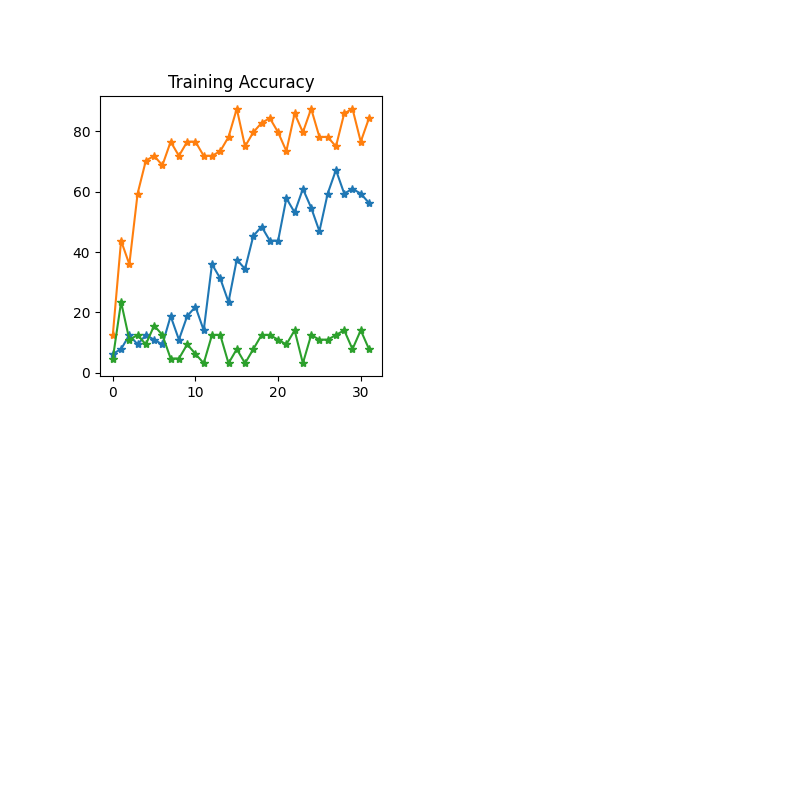

IndexError: list index out of range

In [139]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(activations)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(activations)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(activations)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(activations)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.suptitle("Various activation functions")
plt.show()

In [ ]:
##################################################
#Write down the accuracies and report your observations
##################################################
# Softplus



<b> Part - (3) : Understanding optimization algorithms </b>

In this part you will learn to use different optimiztion algorithm apart from SGD.

1. Using the best activation function from Part - (2), train the classification network using Adam optimization algorithm.
3. Compare the accuracy of the networks trained with SGD and Adam optimization algorithms.
4. Report your observations.

In [145]:
##################################################
#Train the network using Adam optimizer
##################################################

device = "cuda:3"
opts = ["SGD", "Adam", "RMSprop"]
tA = []
vA = []
tL = []
vL = []
for i, opt in enumerate(opts):
    net = mnist_classifier(784, 10, activations=[act]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    if opt != "SGD":
        optimizer = eval("optim.{}(net.parameters(), lr=0.001)".format(opt))
    else:
        optimizer = eval("optim.{}(net.parameters(), lr=0.001, momentum=0.9)".format(opt))

#     print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


    batchSize = 64
    nEpochs = 5
    regularisation_constant = 0
    validationFrequency = 1
    p_drop = 0.0


    met = trainer(net, X_train[:2000], Y_train_one[:2000], X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Optimizer:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(opt, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Optimizer:- SGD, Training Accuracy:- 41.064453125, Training Loss:- 2.0848686695098877, Validation Accuracy:- 40.34843826293945, Validation Loss:- 0.032784208137542015

Optimizer:- Adam, Training Accuracy:- 72.265625, Training Loss:- 0.8816249370574951, Validation Accuracy:- 70.92093658447266, Validation Loss:- 0.014253101156465709

Optimizer:- RMSprop, Training Accuracy:- 8.935546875, Training Loss:- 2.798065662384033, Validation Accuracy:- 10.335000038146973, Validation Loss:- 0.0433670650601387



<IPython.core.display.Javascript object>


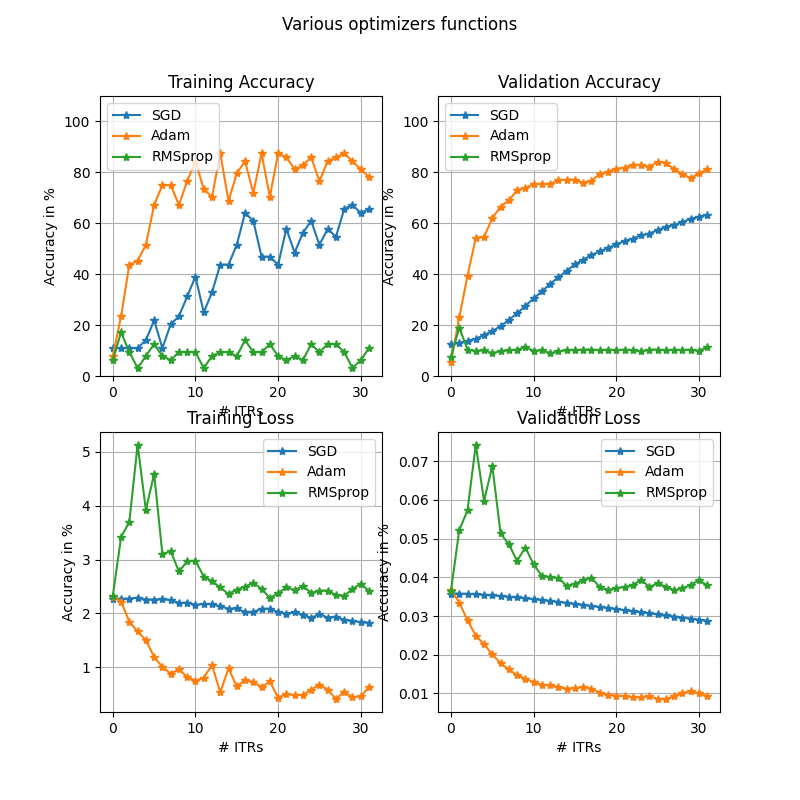

In [146]:
##################################################
#Test the network
##################################################

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(opts)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(opts)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(opts)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(opts)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.suptitle("Various optimizers functions")
plt.show()


In [ ]:
##################################################
#Compare the accuracies an deport your observations
##################################################








<b> Part - (4) : Understanding regularization methods </b>

In this part of the assignment, you will learn about a few regularization techniques to reduce the overfitting problem.</br>
Using the above built network, inculcate the following techniques to reduce the overfitting by retraining the network efficiently. Write down the accuracies for each case.

1. Weight regularization
2. Dropout with a probability of 0.5
3. Early stopping


In [ ]:
##################################################
#Training with weight regularization
##################################################












In [ ]:
##################################################
#Training with dropout strategy
##################################################











In [ ]:
##################################################
#Training with early stopping criterion
##################################################






<b> Part - (5) : Understanding vanishing gradients problem </b> </br>
Use the best trained models in part (4) to understand the problem of vanishing gradient.
1. Plot the norm of the gradients for various layers with/without weight regularization
3. Repeat the same experiments with skip connections. You can choose your desired skip connections in the network by increasing the number of hidden layers.
4. Report your observations on the differences between the plots in the above two cases.

In [ ]:
##################################################
#Plots without skip connections
##################################################













In [ ]:
##################################################
#Plots with skip connections
##################################################








In [ ]:
##################################################
#Observations
##################################################






